In [ ]:
pip install SimpleITK
pip install nibabel

In [7]:
import SimpleITK as sitk
import numpy as np
from scipy import ndimage
import math
import cv2
import random
import sys
import math
import requests
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import nibabel as nib
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler


from sklearn.model_selection import train_test_split
from torchvision import datasets, models, transforms
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

from sklearn.metrics import confusion_matrix

In [44]:
%run utils.ipynb

# Visualizing one image

In [10]:
# image = sitk.ReadImage("../picai_public_images_fold1/10010/10010_1000010_t2w.mha") #need to add ../ to go up one directory KIM
image = sitk.ReadImage("../data/picai_public_images_fold1/10010/10010_1000010_t2w.mha") #need to add ../ to go up one directory EMILIA

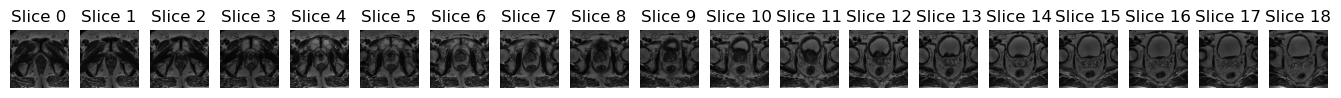

In [11]:
#this is to display the image
image_array = sitk.GetArrayFromImage(image)

# Display slices of the image using Matplotlib
num_slices = image_array.shape[0]  # Assuming the first dimension is the number of slices
fig, axes = plt.subplots(1, num_slices, figsize=(17, 4))
for i in range(num_slices):
    axes[i].imshow(image_array[i], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Slice {i}")
plt.show()

# Merging images with label in one dictionary

In [12]:
# directory = "/Users/kimberlyllajarunaperalta/Documents/ComputerVision/project/picai_public_images_fold1"
directory = "../data/picai_public_images_fold1"

In [70]:
##### ADD A KEY FOR AGE 
dict_images = {}

for folder in os.listdir(directory):
    folder_path = os.path.join(directory, folder) # /Users/kimberlyllajarunaperalta/Documents/ComputerVision/project/picai_public_images_fold1/10010/10010_1000010
    if os.path.isdir(folder_path):
        for file_name in os.listdir(folder_path):
            if "t2w" in file_name and file_name.endswith('.mha'):
                full_path = os.path.join(directory, folder, file_name)
                if os.path.exists(full_path):
                    short_name = '_'.join(file_name.split('_')[:2])
                    image = sitk.ReadImage(full_path)
                    dict_images[short_name] = {'image': image, 'case_pca': None, 'patient_age': None, 'patient_id': None}

In [71]:
dict_images['10010_1000010']

{'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x2de601740> >,
 'case_pca': None,
 'patient_age': None,
 'patient_id': None}

In [72]:
#size of the dictionary
len(dict_images)

298

We stored 3 things: 
* the nii files that have the color coded images 
* the labels for each image (from csv file)
* the age of patients for each image (from csv file)

# Opening nii files

In [73]:
# path = '../10035_1000035.nii'


In [74]:
# img = nib.load(path).get_fdata()
# img.shape

In [75]:
# print(f"The .nii files are stored in memory as numpy's: {type(img)}.")


In [76]:
# plt.style.use('default')
# fig, axes = plt.subplots(4,4, figsize=(12,12))
# for i, ax in enumerate(axes.reshape(-1)):
#     ax.imshow(img[:,:,1 + i])
# plt.show()

# Using the CSV file to get the labels and patients' age

In this spreadsheet, there is a column "lesion_GS", which lists the outcomes:

Gleason score (GS) assigned to each lesion after histopathologic analysis, where scores for different lesions are separated by , (commas). If its value is missing, then no tissue sampling procedure was performed; indicating a negative MRI study. If its value is N/A only for specific lesion(s), then those lesion(s) (as observed in radiology) were not biopsied or graded in histopathology (typically the case for PI-RADS 1-2 lesions).

This means that any case that contains a Gleason score of 7 (3+4 or higher) harbors csPCa, while all other cases are considered negative for csPCa. For more details on how this ground truth was derived, you can also check out our study design.


In [77]:
# labels_path = "../marksheet.csv"
labels_path = "../data/marksheet.csv"

In [78]:
df = pd.read_csv(labels_path)

In [79]:
df.head(100)

,patient_id,study_id,mri_date,patient_age,psa,psad,prostate_volume,histopath_type,lesion_GS,lesion_ISUP,case_ISUP,case_csPCa
0,10000,1000000,2019-07-02,73,7.70,NaN,55.0,MRBx,0+0,0,0,NO
1,10001,1000001,2016-05-27,64,8.70,0.09,102.0,NaN,NaN,NaN,0,NO
2,10002,1000002,2021-04-18,58,4.20,0.06,74.0,NaN,NaN,NaN,0,NO
3,10003,1000003,2019-04-05,72,13.00,NaN,71.5,SysBx,0+0,0,0,NO
4,10004,1000004,2020-10-21,67,8.00,0.10,78.0,SysBx+MRBx,"0+0,0+0","0,0",0,NO
...,...,...,...,...,...,...,...,...,...,...,...,...
95,10095,1000095,2017-02-09,65,9.20,NaN,60.0,MRBx,0+0,0,0,NO
96,10096,1000096,2011-12-31,64,22.33,0.66,34.0,MRBx,0+0,0,0,NO
97,10097,1000097,2018-11-27,66,15.01,NaN,32.0,MRBx,3+4,2,2,YES
98,10098,1000098,2012-03-29,69,12.00,0.17,69.0,NaN,NaN,NaN,0,NO


### Evaluating class imbalance

In [80]:
df['case_csPCa'].value_counts()

case_csPCa
NO     1075
YES     425
Name: count, dtype: int64

Combining them both

## Combining patient_id and study_id to get the full differentiator per patient

In [81]:
df['full_name'] = df['patient_id'].astype(str) + '_' + df['study_id'].astype(str)

In [82]:
df

,patient_id,study_id,mri_date,patient_age,psa,psad,prostate_volume,histopath_type,lesion_GS,lesion_ISUP,case_ISUP,case_csPCa,full_name
0,10000,1000000,2019-07-02,73,7.70,NaN,55.0,MRBx,0+0,0,0,NO,10000_1000000
1,10001,1000001,2016-05-27,64,8.70,0.09,102.0,NaN,NaN,NaN,0,NO,10001_1000001
2,10002,1000002,2021-04-18,58,4.20,0.06,74.0,NaN,NaN,NaN,0,NO,10002_1000002
3,10003,1000003,2019-04-05,72,13.00,NaN,71.5,SysBx,0+0,0,0,NO,10003_1000003
4,10004,1000004,2020-10-21,67,8.00,0.10,78.0,SysBx+MRBx,"0+0,0+0","0,0",0,NO,10004_1000004
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,11471,1001495,2012-08-25,71,12.50,0.21,62.0,MRBx,"3+4,N/A,3+3","2,1",2,YES,11471_1001495
1496,11472,1001496,2019-06-28,81,5.28,0.12,44.0,SysBx+MRBx,3+4,2,2,YES,11472_1001496
1497,11473,1001497,2017-09-24,56,29.60,0.34,87.0,MRBx,0+0,0,0,NO,11473_1001497
1498,11474,1001498,2016-05-03,71,12.00,NaN,83.0,MRBx,3+3,1,1,NO,11474_1001498


### Testing

In [83]:
specific_full_name = '10000_1000000'
case_csPCA_value = df.loc[df['full_name'] == specific_full_name, 'case_csPCa'].iloc[0]
case_csPCA_value

'NO'

## Adding to a dictionary based on thier full name

In [86]:
not_found = 0
found = 0

for f in df['full_name']:
    if f in dict_images:
        print(f"Found {f}")
        case_csPCa_value = df.loc[df['full_name'] == f, 'case_csPCa'].iloc[0]
        patient_age = df.loc[df['full_name'] == f, 'patient_age'].iloc[0]
        #converting to 0 and 1
        dict_images[f]['case_pca'] = 0 if case_csPCa_value == 'NO' else 1 if case_csPCa_value == 'YES' else None
        dict_images[f]['patient_age'] = patient_age
        dict_images[f]['patient_id'] = f

        found += 1
    else:
        print(f"Could not find {f}")
        not_found += 1

Could not find 10000_1000000
Could not find 10001_1000001
Could not find 10002_1000002
Could not find 10003_1000003
Could not find 10004_1000004
Could not find 10005_1000005
Could not find 10006_1000006
Could not find 10007_1000007
Found 10008_1000008
Could not find 10009_1000009
Found 10010_1000010
Found 10011_1000011
Could not find 10012_1000012
Could not find 10013_1000013
Could not find 10014_1000014
Could not find 10015_1000015
Found 10016_1000016
Could not find 10017_1000017
Could not find 10018_1000018
Found 10019_1000019
Could not find 10020_1000020
Could not find 10021_1000021
Could not find 10022_1000022
Could not find 10023_1000023
Found 10024_1000024
Could not find 10025_1000025
Found 10026_1000026
Could not find 10027_1000027
Could not find 10028_1000028
Could not find 10029_1000029
Could not find 10030_1000030
Found 10031_1000031
Could not find 10032_1000032
Could not find 10033_1000033
Could not find 10034_1000034
Could not find 10035_1000035
Found 10036_1000036
Could no

In [87]:
found, not_found

(298, 1202)

In [88]:
dict_images

{'10268_1000272': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x2de56b510> >,
  'case_pca': 1,
  'patient_age': 76,
  'patient_id': '10268_1000272'},
 '10892_1000908': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x2de568660> >,
  'case_pca': 0,
  'patient_age': 64,
  'patient_id': '10892_1000908'},
 '11385_1001409': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x2de56bcc0> >,
  'case_pca': 1,
  'patient_age': 75,
  'patient_id': '11385_1001409'},
 '10401_1000407': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x2de56a700> >,
  'case_pca': 0,
  'patient_age': 63,
  'patient_id': '10401_1000407'},
 '11371_1001394': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x2de56bab0> >,
  'case_pca': 0,
  'patient_age': 52,
  'patient_id': '11371_1001394'},


### Evaluating class imbalance in final sample

In [37]:
# Extract 'case_pca' values from dictionary values
case_pca_values = [item['case_pca'] for item in dict_images.values()]

# Count occurrences of 'YES' and 'NO'
counts = Counter(case_pca_values)
yes_count = counts[1]
no_count = counts[0]

print(f"Count of 'YES': {yes_count}")
print(f"Count of 'NO': {no_count}")

Count of 'YES': 77
Count of 'NO': 221


In [38]:
#our dictionary with the T2w images and the case_csPCa values
dict_images

{'10268_1000272': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x2c3544720> >,
  'case_pca': 1,
  'patient_age': 76},
 '10892_1000908': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x2c3545c20> >,
  'case_pca': 0,
  'patient_age': 64},
 '11385_1001409': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x2c35d2e50> >,
  'case_pca': 1,
  'patient_age': 75},
 '10401_1000407': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x2c35d3fc0> >,
  'case_pca': 0,
  'patient_age': 63},
 '11371_1001394': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x2c35d2e20> >,
  'case_pca': 0,
  'patient_age': 52},
 '10895_1000911': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x2c35d2d90> >,
  'case_pca': 1,
  'patient_age': 56}

In [39]:
dict_images['10010_1000010']

{'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x2c35cac70> >,
 'case_pca': 0,
 'patient_age': 67}

# Image Preprocessing

In [45]:
## Images
images = [forresnet(entry['image']) for entry in dict_images.values()]

Original shape: (384, 384)
Shape after adding dimension: (384, 384, 1)
Resized shape: (224, 224, 1)
Shape after squeezing: (224, 224)
Shape after stacking: (224, 224, 3)
Shape after normalization: (224, 224, 3)
Original shape: (640, 640)
Shape after adding dimension: (640, 640, 1)
Resized shape: (224, 224, 1)
Shape after squeezing: (224, 224)
Shape after stacking: (224, 224, 3)
Shape after normalization: (224, 224, 3)
Original shape: (1024, 1024)
Shape after adding dimension: (1024, 1024, 1)
Resized shape: (224, 224, 1)
Shape after squeezing: (224, 224)
Shape after stacking: (224, 224, 3)
Shape after normalization: (224, 224, 3)
Original shape: (384, 384)
Shape after adding dimension: (384, 384, 1)
Resized shape: (224, 224, 1)
Shape after squeezing: (224, 224)
Shape after stacking: (224, 224, 3)
Shape after normalization: (224, 224, 3)
Original shape: (384, 384)
Shape after adding dimension: (384, 384, 1)
Resized shape: (224, 224, 1)
Shape after squeezing: (224, 224)
Shape after stacki

# Train Test Split

In [64]:
labels = [entry['case_pca'] for entry in dict_images.values()]
ages = [entry['patient_age'] for entry in dict_images.values()]

X_train, X_test, y_train, y_test, age_train, age_test = train_test_split(images, labels, ages, test_size=0.2, random_state = 42)

#split for validations sets
X_train, X_val, y_train, y_val, age_train, age_val = train_test_split(X_train, y_train, age_train, test_size=0.2, random_state = 42)


X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)
age_train = np.array(age_train)
age_val = np.array(age_val)
age_test = np.array(age_test)

### Evaluating class imbalance in train, test, and validation sets

In [65]:
# Count labels in X_train
train_label_counts = Counter(y_train)
print("Train Label Counts:", train_label_counts)

# Count labels in X_val
val_label_counts = Counter(y_val)
print("Validation Label Counts:", val_label_counts)

# Count labels in X_test
test_label_counts = Counter(y_test)
print("Test Label Counts:", test_label_counts)


Train Label Counts: Counter({0: 142, 1: 48})
Validation Label Counts: Counter({0: 37, 1: 11})
Test Label Counts: Counter({0: 42, 1: 18})


In [66]:
X_train.shape, X_val.shape, X_test.shape

((190, 224, 224, 3), (48, 224, 224, 3), (60, 224, 224, 3))

In [68]:
y_train

array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [67]:
age_train

array([77, 67, 76, 66, 60, 58, 59, 66, 58, 60, 70, 73, 68, 65, 69, 62, 52,
       63, 61, 69, 62, 66, 47, 64, 70, 68, 67, 69, 58, 63, 56, 76, 81, 73,
       69, 69, 74, 67, 59, 68, 58, 83, 69, 76, 68, 72, 55, 69, 64, 56, 70,
       43, 63, 83, 69, 65, 62, 77, 70, 67, 75, 69, 65, 50, 64, 67, 68, 66,
       66, 61, 57, 75, 68, 70, 60, 76, 52, 72, 64, 59, 73, 62, 75, 67, 63,
       63, 72, 71, 66, 57, 39, 68, 63, 63, 66, 58, 64, 66, 66, 62, 71, 73,
       61, 68, 57, 59, 71, 60, 74, 67, 62, 81, 52, 62, 61, 75, 69, 62, 62,
       42, 71, 52, 68, 68, 74, 63, 59, 64, 68, 68, 58, 73, 73, 66, 54, 64,
       63, 65, 66, 55, 70, 54, 62, 63, 64, 48, 61, 64, 65, 70, 72, 77, 77,
       62, 69, 75, 67, 71, 75, 80, 68, 71, 72, 59, 71, 74, 75, 55, 58, 67,
       72, 71, 71, 64, 67, 54, 69, 71, 61, 65, 59, 60, 69, 71, 65, 61, 64,
       63, 62, 61])

In [69]:
age_test

array([58, 73, 78, 72, 67, 78, 51, 64, 56, 69, 59, 70, 64, 59, 72, 73, 74,
       59, 92, 59, 52, 71, 68, 62, 64, 74, 58, 56, 64, 73, 62, 65, 48, 65,
       67, 64, 68, 77, 65, 65, 59, 67, 60, 56, 66, 62, 61, 71, 59, 62, 68,
       77, 66, 58, 64, 66, 65, 70, 61, 76])

# Baseline Model: ResNet50

In [61]:
# model = tf.keras.applications.ResNet50()

In [49]:
# Load pre-trained ResNet-50 model without top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add new classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Add a global average pooling layer
x = Dense(128, activation='relu')(x)  # Add a dense layer
predictions = Dense(1, activation='sigmoid')(x)  # Add an output layer for binary classification

# Combine the base model and new layers
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

94765736/94765736 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

In [50]:
# Train the model
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val))

Epoch 1/10


2024-05-07 08:52:36.335071: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


6/6 [==============================] - 8s 1s/step - loss: 0.7355 - accuracy: 0.6263 - val_loss: 0.5369 - val_accuracy: 0.7708
Epoch 2/10
6/6 [==============================] - 5s 901ms/step - loss: 0.5883 - accuracy: 0.7526 - val_loss: 0.5388 - val_accuracy: 0.7708
Epoch 3/10
6/6 [==============================] - 5s 909ms/step - loss: 0.5345 - accuracy: 0.7474 - val_loss: 0.5229 - val_accuracy: 0.7708
Epoch 4/10
6/6 [==============================] - 5s 897ms/step - loss: 0.5347 - accuracy: 0.7474 - val_loss: 0.5207 - val_accuracy: 0.7917
Epoch 5/10
6/6 [==============================] - 5s 876ms/step - loss: 0.5030 - accuracy: 0.7526 - val_loss: 0.4976 - val_accuracy: 0.7708
Epoch 6/10
6/6 [==============================] - 5s 872ms/step - loss: 0.4887 - accuracy: 0.7526 - val_loss: 0.4917 - val_accuracy: 0.7917
Epoch 7/10
6/6 [==============================] - 5s 884ms/step - loss: 0.4736 - accuracy: 0.7684 - val_loss: 0.4912 - val_accuracy: 0.7917
Epoch 8/10
6/6 [==================

In [51]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

2/2 [==============================] - 1s 598ms/step - loss: 0.5993 - accuracy: 0.7000
Test accuracy: 0.699999988079071


## Performance Evaluation

### Confusion Matrix

2/2 [==============================] - 2s 605ms/step


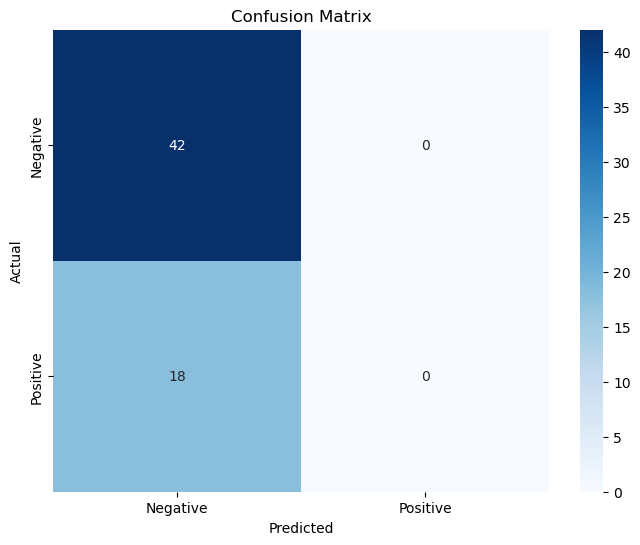

In [52]:
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)

# Define class names
class_names = ['Negative', 'Positive']

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# Experiment 3: Multimodal Model

## Train-test Split

In [56]:
images = [forresnet(entry['image']) for entry in dict_images.values()]

labels = [entry['case_pca'] for entry in dict_images.values()]

# train_images, X_test, train_labels, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# X_train = np.array(X_train)
# X_val = np.array(X_val)
# y_train = np.array(y_train)
# y_val = np.array(y_val)
# X_test = np.array(X_test)
# y_test = np.array(y_test)

In [60]:
X_train, X_test, y_train, y_test, age_train, age_test = train_test_split(images, labels, age, test_size=0.2, random_state=42)

In [58]:
age

[76,
 64,
 75,
 63,
 52,
 56,
 70,
 64,
 67,
 72,
 68,
 69,
 64,
 69,
 73,
 62,
 52,
 62,
 69,
 67,
 73,
 63,
 69,
 62,
 65,
 70,
 66,
 66,
 69,
 66,
 67,
 64,
 63,
 48,
 65,
 65,
 81,
 64,
 81,
 71,
 61,
 74,
 64,
 66,
 52,
 67,
 62,
 61,
 68,
 70,
 77,
 61,
 76,
 71,
 66,
 73,
 68,
 72,
 75,
 76,
 73,
 66,
 67,
 92,
 64,
 66,
 64,
 65,
 74,
 66,
 67,
 72,
 83,
 66,
 66,
 59,
 56,
 67,
 68,
 62,
 66,
 77,
 67,
 54,
 66,
 66,
 68,
 63,
 69,
 83,
 69,
 57,
 65,
 51,
 64,
 64,
 69,
 59,
 68,
 60,
 59,
 68,
 60,
 63,
 71,
 71,
 72,
 68,
 59,
 64,
 42,
 65,
 63,
 68,
 68,
 43,
 56,
 65,
 60,
 59,
 61,
 68,
 68,
 74,
 58,
 69,
 64,
 58,
 58,
 66,
 68,
 72,
 71,
 70,
 50,
 50,
 58,
 62,
 70,
 58,
 59,
 67,
 61,
 62,
 68,
 69,
 81,
 74,
 74,
 67,
 57,
 39,
 71,
 80,
 59,
 52,
 65,
 64,
 64,
 58,
 62,
 62,
 59,
 76,
 62,
 65,
 75,
 52,
 74,
 61,
 67,
 55,
 69,
 69,
 65,
 69,
 70,
 62,
 59,
 71,
 71,
 70,
 55,
 64,
 58,
 77,
 59,
 75,
 62,
 64,
 69,
 75,
 52,
 77,
 70,
 76,
 62,
 70,
 64,
 68,


In [ ]:
## Tabular Data Preprocessing (do after train test split includes age data)

scaler = StandardScaler()

#train
train_age_data = train_df['patient_age'].values.reshape(-1, 1)
standardized_train_age = scaler.fit_transform(train_age_data)

#test
test_age_data = test_df['patient_age'].values.reshape(-1, 1)
standardized_test_age = scaler.transform(test_age_data)

#converting the standardized age data back to 1D arrays
standardized_train_age = standardized_train_age.flatten()
standardized_test_age = standardized_test_age.flatten()

train_df['patient_age_standardized'] = standardized_train_age
test_df['patient_age_standardized'] = standardized_test_age